# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [2]:
import tensorflow as tf
import tensorflow_datasets

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

import math
import numpy as np
import os
import time
from datetime import timedelta
import shutil
from datetime import datetime

## Define Paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    checkpoint_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [4]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [5]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Loading a data from Tensorflow Datasets

In [6]:
data, info = tensorflow_datasets.load(name='glue/sst2',
                                      data_dir=data_dir,
                                      with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/Users/tarrade/tensorflow_datasets/glue/sst2/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/glue/sst2/1.0.0


### Checking baics info from the metadata

In [7]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Stanford Sentiment Treebank consists of sentences from movie reviews and
            human annotations of their sentiment. The task is to predict the sentiment of a
            given sentence. We use the two-way (positive/negative) class split, and use only
            sentence-level labels.',
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=70042,
    splits={
        'test': 1821,
        'train': 67349,
        'validation': 872,
    },
    supervised_keys=None,
    citation="""@

In [8]:
pp.print_info_dataset(info)

Labels:
      ['negative', 'positive']

Number of label:
      2

Structure of the data:
      dict_keys(['sentence', 'label', 'idx'])

Number of entries:
   Train dataset: 67349
   Test dataset:  1821
   Valid dataset: 872



### Checking baics info from the metadata

In [9]:
data

{'test': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'train': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'validation': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>}

In [10]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [11]:
pp.print_info_data(data['train'])

# Structure of the data:

   <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

# Output shape of one entry:
   {'idx': TensorShape([]), 'label': TensorShape([]), 'sentence': TensorShape([])}

# Output types of one entry:
   {'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}

# Output typesof one entry:
   {'idx': <class 'tensorflow.python.framework.ops.Tensor'>, 'label': <class 'tensorflow.python.framework.ops.Tensor'>, 'sentence': <class 'tensorflow.python.framework.ops.Tensor'>}
 

# Shape of the data:

   (67349,)
   ---> 67349 entries
   ---> 1 dim
        dict structure
           dim: 3
           [idx       / label     / sentence ]
           [()        / ()        / ()       ]
           [int32     / int64     / bytes    ]


# Examples of data:
{'idx': 16399,
 'label': 0,
 'sentence': b'for the uninitiated plays better on video with the sound '}
{'idx': 1680,
 'label': 0,
 'sentence': b'like a g

## Define parameters of the model

In [111]:
# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
size_train_dataset = info.splits['train'].num_examples
size_test_dataset = info.splits['test'].num_examples
size_valid_dataset = info.splits['validation'].num_examples
number_label = info.features["label"].num_classes

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_test_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           67349/  1821/   872
Batch size:                32/    32/    64
Step per epoch:          2105/    57/    29
Total number of batch:   6315/   171/    87


## Tokenizer and prepare data for BERT

In [13]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [116]:
# Prepare data for BERT
train_dataset = glue_convert_examples_to_features(data['train'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')
test_dataset = glue_convert_examples_to_features(data['test'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')

In [121]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Check the final data

In [16]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (6315, 2)
   ---> 6315 batches
   ---> 2 dim
        label
           shape: (32,)
        dict structure
           dim: 3
        

In [17]:
pp.print_detail_tokeniser(train_dataset, tokenizer)

 input_ids     ---->    attention_mask    token_type_ids    modified text                 

       101     ---->           1                 1          [ C L S ]                     
      1231     ---->           1                 1          r e                           
     12559     ---->           1                 1          # # v e l                     
     13424     ---->           1                 1          # # a t o r y                 
      4040     ---->           1                 1          n o r                         
      5098     ---->           1                 1          t r u l y                     
      5048     ---->           1                 1          e d                           
      4873     ---->           1                 1          # # g y                       
       118     ---->           1                 1          -                             
       118     ---->           1                 1          -                            

## Building a classification model

### Define optimizerm loss and metric

In [18]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, 
                                     epsilon=1e-08, 
                                     clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

### Define distribute strategy

In [19]:
# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


### Define the callbacks

#### Checkpoints

In [20]:
# Define the checkpoint directory to store the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [21]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         save_weights_only=True),

#### Decaying learning rate

In [22]:
# Function for decaying the learning rate.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [23]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(decay)

#### Print learning rate at the end of each epoch

In [24]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

#### TensorBoard

In [25]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200326-204903


In [26]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200326-204903


In [27]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch')

#### Loss and efficiency per step

In [29]:
class History_per_step(tf.keras.callbacks.Callback):

    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_batch_end(self, batch, logs={}):
        print('DEBUG 1 {}\n'.format(logs))
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        print('\n custom -> loss:{} and acc: {}'.format(logs.get('loss'),logs.get('accuracy')))
        
    def on_test_batch_end(self, batch, logs={}):    
        print('DEBUG 2 {}\n'.format(logs))
        self.val_losses.append(logs.get('loss'))
        self.val_accuracies.append(logs.get('accuracy'))
        print('\n custom -> val loss:{} and val acc: {}'.format(logs.get('loss'),logs.get('accuracy')))
    
    def on_epoch_end(self, batch, logs={}): 
        print('DEBUG 3 {}\n'.format(logs))

In [30]:
histories_per_step = History_per_step()

### Create callbacks

In [31]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback, histories_per_step, histories_per_step]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

ModelCheckpoint need to unpack this tuple by adding *


In [32]:
callbacks = [tensorboard_callback,
             *checkpoint_callback,
             histories_per_step]

### Use TFBertForSequenceClassification

In [67]:
# create and compile the Keras model in the context of strategy.scope
with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',
                                                            num_labels=number_label)
    model.compile(optimizer=optimizer,
                  loss=loss, 
                  metrics=[metric])

In [68]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


### TensorBoard

In [36]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

### Training the model

In [75]:
# time the function
start_time = time.time()

# train the model
history = model.fit(train_dataset, 
                    epochs=2, 
                    steps_per_epoch=5,
                    validation_data=valid_dataset,
                    validation_steps=3,
                    callbacks=callbacks)

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

Train for 5 steps, validate for 3 steps
Epoch 1/2
DEBUG 1 {'batch': 0, 'size': 32, 'loss': 0.74250644, 'accuracy': 0.4375}


 custom -> loss:0.7425064444541931 and acc: 0.4375
1/5 [=====>........................] - ETA: 2:12 - loss: 0.7425 - accuracy: 0.4375DEBUG 1 {'batch': 1, 'size': 32, 'loss': 0.69198537, 'accuracy': 0.46875}


 custom -> loss:0.6919853687286377 and acc: 0.46875
2/5 [===========>..................] - ETA: 1:13 - loss: 0.7172 - accuracy: 0.4688DEBUG 1 {'batch': 2, 'size': 32, 'loss': 0.68764824, 'accuracy': 0.48958334}


 custom -> loss:0.6876482367515564 and acc: 0.4895833432674408
3/5 [=================>............] - ETA: 43s - loss: 0.7074 - accuracy: 0.4896 DEBUG 1 {'batch': 3, 'size': 32, 'loss': 0.663862, 'accuracy': 0.5390625}


 custom -> loss:0.6638619899749756 and acc: 0.5390625
4/5 [=======================>......] - ETA: 20s - loss: 0.6965 - accuracy: 0.5391DEBUG 1 {'batch': 4, 'size': 32, 'loss': 0.5950089, 'accuracy': 0.5625}


 custom -> loss:0.59500

### Visualization

Loss:
  - loss [training dataset]: 0.680
  - loss [validation dataset: 0.573

Accuracy:
  - accuracy [training dataset]: 63.75%
  - accuracy [validation dataset: 81.25%


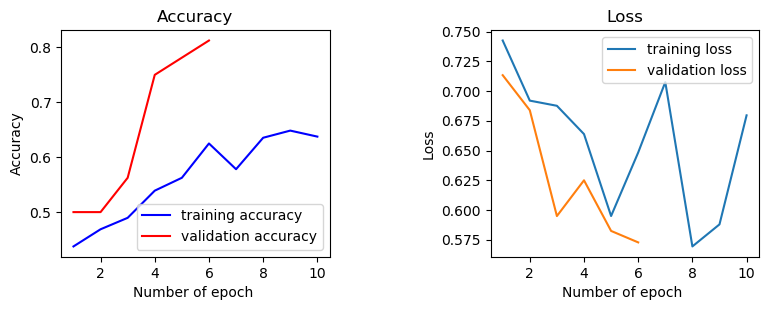

In [78]:
mm.plot_acc_loss(steps_loss_train=range(1,len(histories_per_step.losses)+1), loss_train=histories_per_step.losses,
                 steps_acc_train=range(1,len(histories_per_step.accuracies)+1), accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=range(1,len(histories_per_step.val_losses)+1), loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=range(1,len(histories_per_step.val_accuracies)+1), accuracy_eval=histories_per_step.val_accuracies)

### Get more information

In [86]:
print(model.metrics)
print(model.metrics_names)

['loss', 'accuracy']


In [87]:
history.epoch

[0, 1]

In [91]:
history.params

{'batch_size': None,
 'epochs': 2,
 'steps': 5,
 'samples': 5,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [95]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
# dir(history)

### Exploration of the model's structure

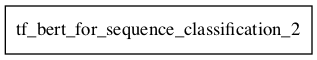

In [80]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [81]:
model.inputs

{'attention_mask': <tf.Tensor 'attention_mask_1:0' shape=(None, 128) dtype=int32>,
 'input_ids': <tf.Tensor 'input_ids_1:0' shape=(None, 128) dtype=int32>,
 'token_type_ids': <tf.Tensor 'token_type_ids_1:0' shape=(None, 128) dtype=int32>}

In [82]:
model.outputs

[<tf.Tensor 'tf_bert_for_sequence_classification_2/Identity:0' shape=(None, 2) dtype=float32>]

In [83]:
model.layers

In [84]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_151 [] []
classifier [] []


### Validation of the model

In [145]:
list(valid_dataset)[0]

({'input_ids': <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
  array([[ 101,  170, 2860, ...,    0,    0,    0],
         [ 101, 3022,  170, ...,    0,    0,    0],
         [ 101,  178, 1821, ...,    0,    0,    0],
         ...,
         [ 101, 1122,  112, ...,    0,    0,    0],
         [ 101, 1122,  112, ...,    0,    0,    0],
         [ 101, 1103, 1273, ...,    0,    0,    0]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(64, 128), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dty

In [124]:
pred=model.predict(valid_dataset)

In [125]:
y_pred = tf.nn.softmax(model.predict(valid_dataset))
y_pred

<tf.Tensor: shape=(872, 2), dtype=float32, numpy=
array([[0.4662328 , 0.5337672 ],
       [0.43010023, 0.5698998 ],
       [0.54952407, 0.45047596],
       ...,
       [0.34734094, 0.6526591 ],
       [0.37869525, 0.6213048 ],
       [0.5305445 , 0.46945548]], dtype=float32)>

In [55]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)
y_pred_argmax

<tf.Tensor: shape=(2616,), dtype=int64, numpy=array([1, 1, 0, ..., 1, 1, 0])>

## Building a classification model 

In [56]:
def keras_building_blocks(number_label):

    # create model
    model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=number_label)

    # hidden layer
    model.add(tf.keras.layers.Dense(512,
                                    input_dim=dim_input,
                                    kernel_initializer=tf.keras.initializers.he_normal(),
                                    bias_initializer=tf.keras.initializers.Zeros(),
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(512,
                                    kernel_initializer=tf.keras.initializers.he_normal(),
                                    bias_initializer=tf.keras.initializers.Zeros(),
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    # last layer
    model.add(tf.keras.layers.Dense(num_classes,
                                    kernel_initializer=tf.keras.initializers.he_normal(),
                                    bias_initializer=tf.keras.initializers.Zeros(),
                                    activation='softmax'))

    return model

In [57]:
input_layer = tf.keras.Input(shape = (128,), dtype='int64')  
#input_layer = tf.keras.Input({'attention_mask': <tf.Tensor 'attention_mask:0' shape=(None, 128) dtype=int32>,
# 'input_ids': <tf.Tensor 'input_ids:0' shape=(None, 128) dtype=int32>,
# 'token_type_ids': <tf.Tensor 'token_type_ids:0' shape=(None, 128) dtype=int32>})
#in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
#in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
#in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
#bert_inputs = [in_id, in_mask, in_segment]   
bert_ini = TFBertModel.from_pretrained('bert-base-cased') (input_layer)
bert = bert_ini[1]    
dropout = tf.keras.layers.Dropout(0.1)(bert)
flat = tf.keras.layers.Flatten()(dropout)
classifier = tf.keras.layers.Dense(units=2)(flat)                  
model2 = tf.keras.Model(inputs=input_layer, outputs=classifier)

In [58]:
bert_ini[0]

<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>

In [59]:
bert_ini[1]

<tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>

In [60]:
model2.inputs

[<tf.Tensor 'input_1:0' shape=(None, 128) dtype=int64>]

In [61]:
model2.outputs

[<tf.Tensor 'dense/Identity:0' shape=(None, 2) dtype=float32>]

In [62]:
for i in train_dataset.take(1):
    print(i[1])
    print(i[0]['input_ids'])

tf.Tensor([0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0], shape=(32,), dtype=int64)
tf.Tensor(
[[  101  1167   175 ...     0     0     0]
 [  101  1123 18456 ...     0     0     0]
 [  101  1376   175 ...     0     0     0]
 ...
 [  101   175 18129 ...     0     0     0]
 [  101 13532  1105 ...     0     0     0]
 [  101  1185  2187 ...     0     0     0]], shape=(32, 128), dtype=int32)


In [63]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [64]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 108310272 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Train and evaluate using tf.keras.Model.fit()
history = model2.fit(train_dataset, 
                     epochs=2, 
                     steps_per_epoch=115)

ValueError: in converted code:

    /Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:510 standardize_input_data
        'for each key in: ' + str(names))

    ValueError: No data provided for "input_1". Need data for each key in: ['input_1']


In [ ]:
# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=2, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)